In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def fun_getNeutronEnergyVSEmissionAngle(energy, angle):
    # returns xRad,y,angle,intp_Y_av : xRad is the angle in radian for the formula, y is the neutron energy at xRad (so this is the "real" value)
    #       angle is the angle in emission radian, intp_Y_av is the neutron energy in MeV for MCNP
    # energy is the energy of the incoming deuterium ion
    # angle is the emission angle in radian
    def mathfun_Eout_vs_angle(energy,angle):
        # energy is the impinging deuterons energy
        # angle is the emission angle
        res = 0.3542 * np.sqrt(energy) * np.cos(angle) + ( np.sqrt( 2.031 * energy * (np.cos(angle))**2 + 39.6502 + 4.0291 * energy ) ) / ( 4.02359755 )
        return res**2

    a = np.arange(0.0,181,0.1)

    #energy = 0.05 # D beam energy in MeV
    xRad = []
    y = []
    for angl in a:
        angl = angl / 180.0 * np.pi
        xRad.append(angl)
        y.append(mathfun_Eout_vs_angle(energy,angl))


    # lookup the xs data for each emission angle --> interpolate between the two closest values
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx,array[idx]

    # find where in the x data (emission angle) the angle that is desired for the MCNP file are located
    xRad = np.asarray(xRad)
    idxAngle = []
    for val in angle:
        idx, nearest = find_nearest(xRad, val)
        idxAngle.append(idx) # append nearest value where that angle is located in the datafile

    # interpolate between the angles: take the interval between two values
    idxAngleCenter = []
    for ii in range(0,len(idxAngle)-1):
        v2 = idxAngle[ii + 1]
        v1 = idxAngle[ii]
        v3 = round((v1+v2)/2,0)
        idxAngleCenter.append(v3)

    # interpolate between the angles: intervals where to evaluate the angles
    idxAngleRange = []
    for ii in range(0,len(idxAngle)):
        if ii is 0:
            idxAngleRange.append([0,idxAngleCenter[ii]])
        elif ii < len(idxAngle)-1:
            idxAngleRange.append([idxAngleCenter[ii-1],idxAngleCenter[ii]])
        else:
            idxAngleRange.append([idxAngleCenter[ii-1], idxAngle[-1]])

    # interpolate between the angles! for example 0 - 10 degree
    intp_Y_av = [] # [-1.0] * len(angle)# interpolated yield values as the average between the two angles (absolute, but not normalized!)
    for pair in idxAngleRange:
        #ii = np.where(idxAngleRange == pair)[0][0]
        val1 = int(pair[0])
        val2 = int(pair[1])
        res = np.mean(y[val1:val2])
        intp_Y_av.append(res)

    return xRad,y,angle,intp_Y_av

# Check if Benoits and my data align

## My data

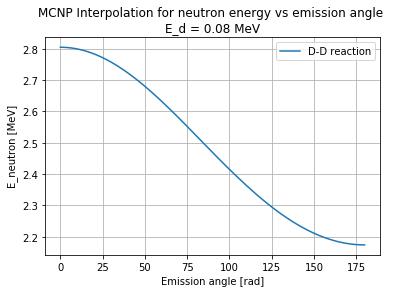

In [23]:
angle_start = 0.0
angle_stop = 180.0
angle_step = 10.0
energy = 80/1000 # MeV

angle_rad = list(map(np.cos,np.arange(angle_start,angle_stop + 1.0, angle_step)))
angle = np.arange(angle_start, angle_stop + 1.0, angle_step)
# convert to radian
angle = (angle / 360.0) * 2 * np.pi
mu = np.cos(angle) # this is the discretization chosen for the MCNP source probability

xRad,y,angle,intp_Y_av = fun_getNeutronEnergyVSEmissionAngle(energy, angle)
data = pd.DataFrame({'angle': xRad, 'energy': y})
data['angle'] = (data['angle']/np.pi) * 180
poly = np.polyfit(data['angle'].values,data['energy'].values,10)

X = np.linspace(0, 180, 100)
poly_y = np.poly1d(poly)(X)
# print(X)


plt.plot(X,poly_y,'-', label='D-D reaction')
plt.ylabel('E_neutron [MeV]')
plt.title('MCNP Interpolation for neutron energy vs emission angle ' + '\n' + 'E_d = '+str(energy) + ' MeV')
plt.xlabel('Emission angle [rad]')
plt.legend(loc='upper right')
# plt.ylim([1.0,2.9])
plt.grid(True)
plt.show()


## Benoits dat

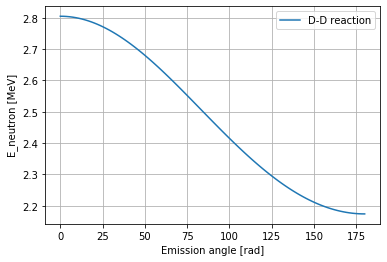

1.3452121194745814e-07

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import yield file
fname_yield = '/Users/hkromer/02_PhD/04_Publiations/01_PaperDrafts/2019/01.CharacterizationPaper/Figures/energy_and_yield_vs_angle/data_from_Benoit/80KeV_yield.csv'

# import energy file
# emission angle in degree, neutron energy in MeV
fname_energy = '/Users/hkromer/02_PhD/04_Publiations/01_PaperDrafts/2019/01.CharacterizationPaper/Figures/energy_and_yield_vs_angle/data_from_Benoit/80kV_energy.xlsx'

data_yield = pd.read_csv(fname_yield, header=0, delimiter=';')
data_yield.columns = ['emission_angle', 'counts']
# print(data_yield.head())
# print(data_yield.info())

data_energy = pd.read_excel(fname_energy, header=None)
data_energy.columns = ['emission_angle', 'neutron_energy']
poly_benoit = np.polyfit(data_energy['emission_angle'].values,data_energy['neutron_energy'].values,10)

X_benoit = np.linspace(0, 180, 100)
poly_y_benoit = np.poly1d(poly_benoit)(X_benoit)
plt.plot(X_benoit,poly_y_benoit,'-', label='D-D reaction')
plt.ylabel('E_neutron [MeV]')
plt.xlabel('Emission angle [rad]')
plt.legend(loc='upper right')
# plt.ylim([1.0,2.9])
plt.grid(True)
plt.show()
# print(X)
# print(data_energy.head())
# print(data_energy.info())
np.max(poly_y_benoit-poly_y)

The maximum difference between the two interpolated values is 1.3e-7 which is close enough to 0. The values are the same!

# Plot of neutron energy and yield for some energy and yield values

In [ ]:
%matplotlib inline

### Neutron energy

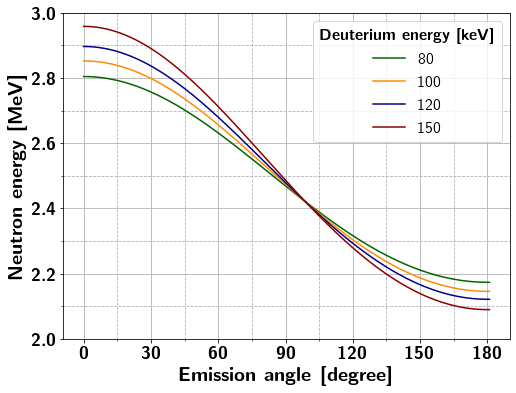

In [54]:
import numpy as np
import pandas as pd
import matplotlib
import os
from matplotlib.ticker import AutoMinorLocator

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


def fun_getNeutronEnergyVSEmissionAngle(energy, angle):
    # returns xRad,y,angle,intp_Y_av : xRad is the angle in radian for the formula, y is the neutron energy at xRad (so this is the "real" value)
    #       angle is the angle in emission radian, intp_Y_av is the neutron energy in MeV for MCNP
    # energy is the energy of the incoming deuterium ion
    # angle is the emission angle in radian
    def mathfun_Eout_vs_angle(energy,angle):
        # energy is the impinging deuterons energy
        # angle is the emission angle
        res = 0.3542 * np.sqrt(energy) * np.cos(angle) + ( np.sqrt( 2.031 * energy * (np.cos(angle))**2 + 39.6502 + 4.0291 * energy ) ) / ( 4.02359755 )
        return res**2

    a = np.arange(0.0,181,0.1)

    #energy = 0.05 # D beam energy in MeV
    xRad = []
    y = []
    for angl in a:
        angl = angl / 180.0 * np.pi
        xRad.append(angl)
        y.append(mathfun_Eout_vs_angle(energy,angl))


    # lookup the xs data for each emission angle --> interpolate between the two closest values
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx,array[idx]

    # find where in the x data (emission angle) the angle that is desired for the MCNP file are located
    xRad = np.asarray(xRad)
    idxAngle = []
    for val in angle:
        idx, nearest = find_nearest(xRad, val)
        idxAngle.append(idx) # append nearest value where that angle is located in the datafile

    # interpolate between the angles: take the interval between two values
    idxAngleCenter = []
    for ii in range(0,len(idxAngle)-1):
        v2 = idxAngle[ii + 1]
        v1 = idxAngle[ii]
        v3 = round((v1+v2)/2,0)
        idxAngleCenter.append(v3)

    # interpolate between the angles: intervals where to evaluate the angles
    idxAngleRange = []
    for ii in range(0,len(idxAngle)):
        if ii is 0:
            idxAngleRange.append([0,idxAngleCenter[ii]])
        elif ii < len(idxAngle)-1:
            idxAngleRange.append([idxAngleCenter[ii-1],idxAngleCenter[ii]])
        else:
            idxAngleRange.append([idxAngleCenter[ii-1], idxAngle[-1]])

    # interpolate between the angles! for example 0 - 10 degree
    intp_Y_av = [] # [-1.0] * len(angle)# interpolated yield values as the average between the two angles (absolute, but not normalized!)
    for pair in idxAngleRange:
        #ii = np.where(idxAngleRange == pair)[0][0]
        val1 = int(pair[0])
        val2 = int(pair[1])
        res = np.mean(y[val1:val2])
        intp_Y_av.append(res)

    return xRad,y,angle,intp_Y_av

angle_start = 0.0
angle_stop = 180.0
angle_step = 10.0
# energies to plot
energies = np.asarray([80, 100, 120, 150]) / 1000# MeV


angle_rad = list(map(np.cos,np.arange(angle_start,angle_stop + 1.0, angle_step)))
angle = np.arange(angle_start, angle_stop + 1.0, angle_step)
# convert to radian
angle = (angle / 360.0) * 2 * np.pi
mu = np.cos(angle) # this is the discretization chosen for the MCNP source probability

data = pd.DataFrame()
# columns: energy in MeV angle in degree
for energy in energies:
    xRad,y,angle,intp_Y_av = fun_getNeutronEnergyVSEmissionAngle(energy, angle)
    col = str(energy)
    data[col] = y
    data['angle_'+col] = (xRad/np.pi) * 180

# make sure the angles are the same
cols_angle = [c for c in data.columns if 'angle' in c]
for c in cols_angle:
    assert len(data[c]) == len(xRad)
data = data.drop(columns=cols_angle)
data['angle'] = (xRad/np.pi) * 180
# poly = np.polyfit(data['angle'].values,data['energy'].values,10)

# X = np.linspace(0, 180, 100)
# poly_y = np.poly1d(poly)(X)
# # print(X)

# PLOT
fig, ax1 = plt.subplots(figsize=(8, 6))

fs = 20
markersize = 8
colors = ['darkgreen', 'darkorange', 'darkblue', 'darkred']

for energy, color in zip(energies, colors):
    label = int(energy*1000)
    ax1.plot(data['angle'].values,data[str(energy)].values,'-', label=label, color=color)
    
ax1.set_xlabel(r"\textbf{Emission angle [degree]}", fontsize=fs)
ax1.set_ylabel(r"\textbf{Neutron energy [MeV]}", fontsize=fs)
ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params(axis='y', labelsize=fs-2)
ax1.set_ylim(2.1,3.0)
ax1.set_yticks(np.arange(2.0,3.1,0.2))
# ax1.set_xlim()
ax1.set_xticks(np.arange(0,180+30,30))
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
leg1 = plt.legend(loc='upper right', fontsize=fs-4)
leg1.set_title(r"\textbf{Deuterium energy [keV]}", prop = {'size': fs-4})
ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')

plt.grid(True)
plt.show()


In [36]:
data

,0.08,0.1,0.12,0.15,angle
0,2.804617,2.852382,2.896676,2.958387,0.0
1,2.804617,2.852382,2.896675,2.958387,0.1
2,2.804615,2.852380,2.896673,2.958384,0.2
3,2.804612,2.852377,2.896670,2.958380,0.3
4,2.804608,2.852372,2.896665,2.958375,0.4
5,2.804604,2.852367,2.896659,2.958368,0.5
6,2.804598,2.852360,2.896651,2.958359,0.6
7,2.804591,2.852352,2.896642,2.958349,0.7
8,2.804582,2.852343,2.896632,2.958337,0.8
9,2.804573,2.852332,2.896620,2.958324,0.9
